In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = False
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['font.family']="serif"
plt.rc("text", usetex=True)
plt.rc("font", size=22)

# 1) Import the Excel file
file_path = "17_9 Gouy.xlsx"
df = pd.read_excel(file_path)


In [15]:
delm = df.iloc[1:, 10]  # g
Hsq = df.iloc[1:, 6]  # G^2

x=Hsq/100
y=delm

mask = (x >= 0) & (y >= 0)

x=x[mask]
y=y[mask]

print(x)
print(y)

1          144.0
2        71824.0
3       162409.0
4       290521.0
5      448230.25
6      644006.25
7       872356.0
8     1128906.25
9     1391220.25
10    1670556.25
11     1918225.0
Name: Unnamed: 6, dtype: object
1          0
2     0.0017
3     0.0032
4     0.0055
5     0.0081
6     0.0112
7     0.0147
8     0.0179
9     0.0218
10    0.0255
11    0.0285
Name: Unnamed: 10, dtype: object


In [16]:
# 1. Combine into a new DataFrame for easy cleaning
data_to_fit = pd.DataFrame({'x': x, 'y': y})

# 2. Force both columns to be numeric. 
#    errors='coerce' is critical: it turns any bad values (like '') into NaN
data_to_fit['x'] = pd.to_numeric(data_to_fit['x'], errors='coerce')
data_to_fit['y'] = pd.to_numeric(data_to_fit['y'], errors='coerce')

# 3. Drop any rows that have NaN in *either* 'x' or 'y'
#    This is the key step to prevent the numpy error.
data_to_fit_cleaned = data_to_fit.dropna()

# 4. (Optional) Apply your mask from before
#    This will remove any rows where x or y are negative
mask = (data_to_fit_cleaned['x'] >= 0) & (data_to_fit_cleaned['y'] >= 0)
data_to_fit_cleaned = data_to_fit_cleaned[mask]

# 5. Now, get the clean numpy arrays for statsmodels
#    (Note: You might want to filter out the 0,0 point for a better fit)
data_to_fit_final = data_to_fit_cleaned.iloc[1:] # Skip the (0,0) point
x_clean = data_to_fit_final['x']
y_clean = data_to_fit_final['y']

x=x_clean
y=y_clean


[statsmodels results (no intercept)]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              3088.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):                    9.95e-13
Time:                        11:40:02   Log-Likelihood:                          56.086
No. Observations:                  10   AIC:                                     -110.2
Df Residuals:                       9   BIC:                                     -109.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

/home/anargha/anaconda3/envs/base2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)



Plot saved to plot.png


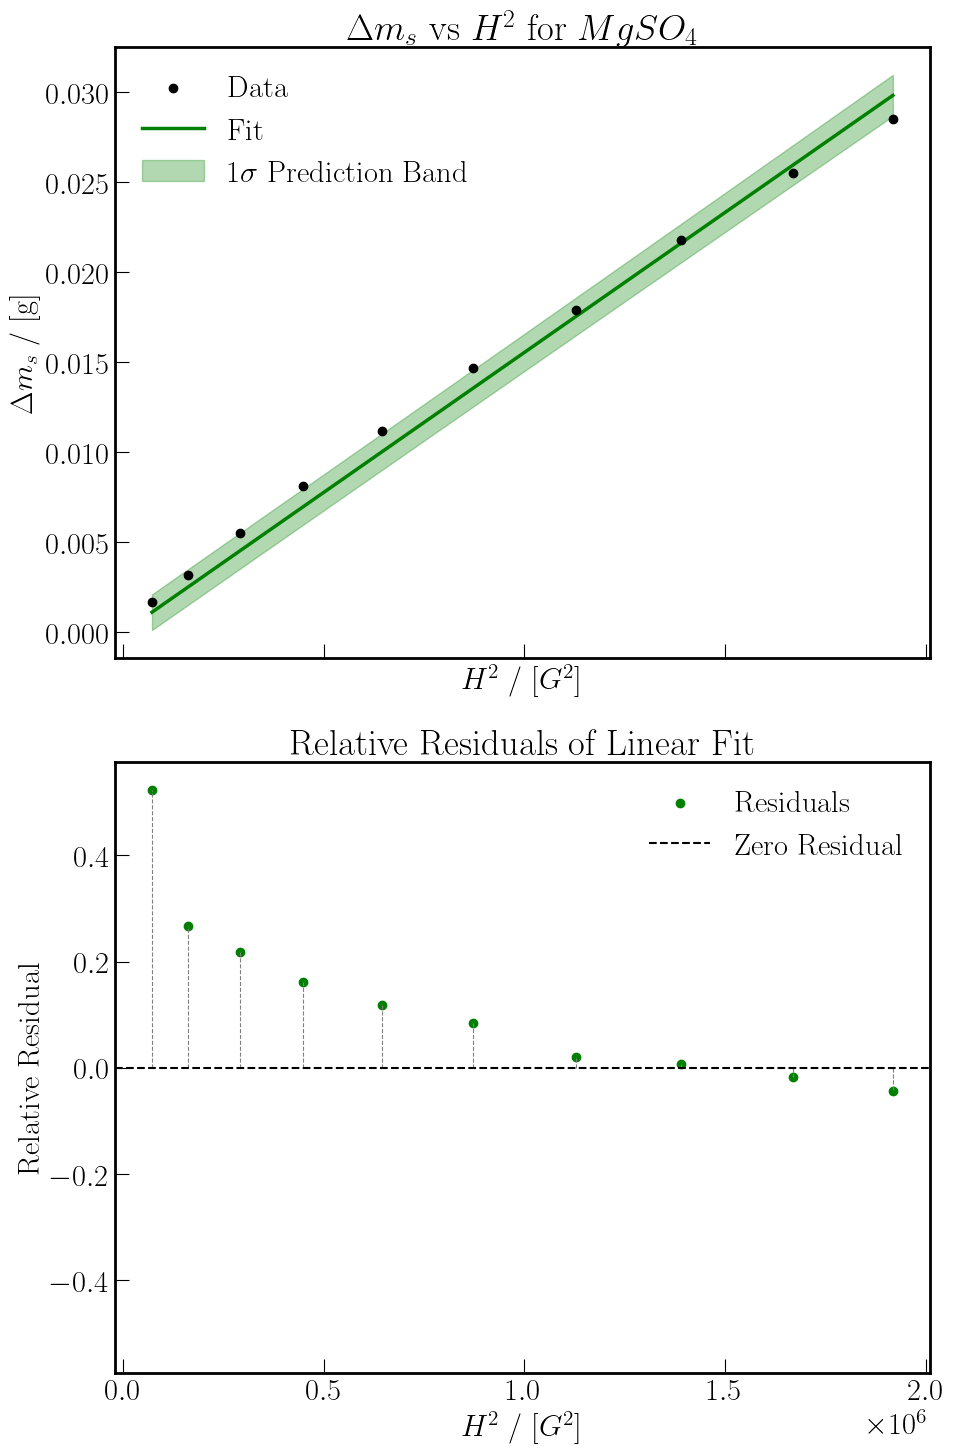

In [17]:
X_sm = x_clean.values  
model = sm.OLS(y_clean.values, X_sm)
results = model.fit()

print("\n[statsmodels results (no intercept)]")
print(results.summary())
print(f"R^2 (statsmodels): {results.rsquared}")

# Extract parameters and covariance matrix
params = results.params
cov = results.cov_params()
errors = np.sqrt(np.diag(cov))

print("\nFitted parameters:")
print(params)
print("\nCovariance matrix:")
print(cov)
print("\nParameter uncertainties (1-sigma):")
print(errors)

# --- Build prediction grid ---
x_pred = np.linspace(x_clean.min(), x_clean.max(), 200)
X_pred = x_pred   # No constant needed here either

# --- Get predictions and intervals ---
pred_summary = results.get_prediction(X_pred).summary_frame(alpha=0.317)  # 1-sigma

y_pred = pred_summary['mean']
pred_ci_lower = pred_summary['mean_ci_lower']    # Confidence interval
pred_ci_upper = pred_summary['mean_ci_upper']
pred_pi_lower = pred_summary['obs_ci_lower']     # Prediction interval
pred_pi_upper = pred_summary['obs_ci_upper']

# --- Plot with error bands ---
fig, axs = plt.subplots(2, 1, figsize=(10,15), sharex=True)
axs[0].scatter(x_clean, y_clean, label="Data", color="black", zorder=10)
axs[0].plot(x_pred, y_pred, label="Fit", color="green", linewidth=2.5)

# Prediction interval (wide)
axs[0].fill_between(x_pred, pred_pi_lower, pred_pi_upper,
                 color="green", alpha=0.3, label=r"$1\sigma$ Prediction Band")

# Optional: Confidence interval (narrower)
# axs[0].fill_between(x_pred, pred_ci_lower, pred_ci_upper,
#                  color="blue", alpha=0.3, label=r"$1\sigma$ Confidence Band")

axs[0].set_ylabel(r"$\Delta m_s$ / [g]")
axs[0].set_xlabel(r"$H^2$ / [$G^2$]")
axs[0].set_title(r"$\Delta m_s$ vs $H^2$ for $MgSO_4$")
axs[0].legend()
# --- Compute fitted values ---
y_fit = results.predict(X_sm) # X_sm is already x_clean.values

# --- Compute relative residuals ---
# Use .values to avoid index mismatch
residuals = (y_clean.values - y_fit) / y_fit

# --- Residual plot ---
axs[1].scatter(x_clean, residuals, color="green", label="Residuals")

# Drop perpendicular (vertical) lines from residuals to 0 line
for xi, ri in zip(x_clean, residuals):
    axs[1].plot([xi, xi], [0, ri], color="gray", linestyle="--", linewidth=0.8)

axs[1].axhline(0, color="black", linestyle="--", label="Zero Residual")
axs[1].set_xlabel(r"$H^2$ / [$G^2$]")
axs[1].set_ylabel(r"Relative Residual")
axs[1].set_title("Relative Residuals of Linear Fit")
axs[1].legend()

# Set y-axis limits for residuals to be symmetric if needed
max_res = np.abs(residuals).max() * 1.1
if max_res > 0:
    axs[1].set_ylim(-max_res, max_res)

plt.tight_layout()
plt.savefig('plot.png')

print("\nPlot saved to plot.png")